# 🧭 QAOA para TSP no IBM Quantum

## Execução em Hardware Quântico Real

Este notebook implementa o TSP usando QAOA para execução no **IBM Quantum Cloud**.

### Backends Disponíveis na sua Conta
| Nome | Qubits | Processador | Tempo de Espera |
|------|--------|-------------|------------------|
| ibm_fez | 156 | Heron r2 | ~1s |
| ibm_marrakesh | 156 | Heron r2 | - |
| ibm_torino | 133 | Heron r1 | - |

### Problemas Testados
- **3 cidades**: 9 qubits ✅
- **4 cidades**: 16 qubits ✅

---
## 📦 Instalação e Imports

In [ ]:
# Instalar/atualizar pacotes necessários (descomente se necessário)
# !pip install qiskit>=1.0
# !pip install qiskit-ibm-runtime
# !pip install qiskit-aer

In [1]:
# Imports
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
from itertools import permutations
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


---
## 🔑 Configuração do IBM Quantum

Suas credenciais já estão configuradas abaixo.

In [17]:
# Substitua pelo valor copiado da sua tela (Detalhes -> CRN)
MEU_CRN = "crn:v1:bluemix:public:quantum-computing:us-east:a/b58cd9ceef164e4586608dca729daacc:6117674a-f3e7-4bc3-8062-30e14b62d3be::"

service = QiskitRuntimeService(channel="ibm_cloud", instance=MEU_CRN)
print("✅ Conectado com sucesso via CRN!")

✅ Conectado com sucesso via CRN!


In [3]:
# =============================================================================
# SUAS CREDENCIAIS IBM QUANTUM
# =============================================================================

# Salvar credenciais (execute apenas UMA VEZ, depois pode comentar)
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="xxxx",
    instance="ibm-q/open/main",
    overwrite=True
)

print("✅ Credenciais salvas com sucesso!")

✅ Credenciais salvas com sucesso!


In [6]:
# =============================================================================
# CONECTAR AO IBM QUANTUM
# =============================================================================

# Inicializa o serviço especificando a instância (CRN)
service = QiskitRuntimeService(channel="ibm_cloud", instance='crn:v1:bluemix:public:quantum-computing:us-east:a/b58cd9ceef164e4586608dca729daacc:6117674a-f3e7-4bc3-8062-30e14b62d3be::')

print("✅ Conectado ao IBM Quantum!")

# Listar backends para confirmar acesso
print("\n📡 Backends disponíveis na sua conta:")
print("-" * 60)
backends = service.backends()
for b in backends:
    status = "🟢" if b.status().operational else "🔴"
    print(f"   {status} {b.name}: {b.num_qubits} qubits")

✅ Conectado ao IBM Quantum!

📡 Backends disponíveis na sua conta:
------------------------------------------------------------
   🟢 ibm_fez: 156 qubits
   🟢 ibm_marrakesh: 156 qubits
   🟢 ibm_torino: 133 qubits


In [8]:
# =============================================================================
# SELECIONAR BACKEND
# =============================================================================

# Opção 1: ibm_fez (156 qubits, Heron r2) - menor tempo de espera
backend = service.backend("ibm_fez")

# Opção 2: Outros backends disponíveis (descomente para usar)
# backend = service.backend("ibm_marrakesh")  # 156 qubits, Heron r2
# backend = service.backend("ibm_torino")     # 133 qubits, Heron r1

# Opção 3: Selecionar automaticamente o menos ocupado
# backend = service.least_busy(min_num_qubits=16, operational=True)

print(f"\n🎯 Backend selecionado: {backend.name}")
print(f"   Qubits disponíveis: {backend.num_qubits}")
print(f"   Status: {'Operacional ✅' if backend.status().operational else 'Offline ❌'}")


🎯 Backend selecionado: ibm_fez
   Qubits disponíveis: 156
   Status: Operacional ✅


---
## 📊 Definição do Problema TSP

In [9]:
# Matrizes de distâncias (3 e 4 cidades)
graphs = {
    3: np.array([
        [0, 10, 15],
        [10, 0, 20],
        [15, 20, 0]
    ], dtype=float),
    
    4: np.array([
        [0, 1, 50, 50],
        [1, 0, 2, 50],
        [50, 2, 0, 3],
        [50, 50, 3, 0]
    ], dtype=float)
}

for n, D in graphs.items():
    print(f"\n📍 Matriz D ({n} cidades) - {n**2} qubits:")
    print(D.astype(int))


📍 Matriz D (3 cidades) - 9 qubits:
[[ 0 10 15]
 [10  0 20]
 [15 20  0]]

📍 Matriz D (4 cidades) - 16 qubits:
[[ 0  1 50 50]
 [ 1  0  2 50]
 [50  2  0  3]
 [50 50  3  0]]


---
## 🔧 Funções do QAOA para TSP

In [10]:
def qubit_index(cidade, tempo, n):
    """Mapeia (cidade, tempo) para índice do qubit."""
    return cidade * n + tempo


def construir_hamiltoniano_tsp(D, penalty_multiplier=2.0):
    """
    Constrói os coeficientes do Hamiltoniano de custo para o TSP.
    H_QUBO = H_dist + A*H_p1 + A*H_p2
    Mapeamento: x_{i,t} → (I - Z_{i,t})/2
    """
    n = len(D)
    A = penalty_multiplier * np.max(D) * n
    
    h = {q: 0.0 for q in range(n * n)}
    J = {}
    
    # H_dist
    for i in range(n):
        for j in range(n):
            if i != j:
                d_ij = D[i, j]
                for t in range(n):
                    t_next = (t + 1) % n
                    q_a = qubit_index(i, t, n)
                    q_b = qubit_index(j, t_next, n)
                    h[q_a] -= d_ij / 4
                    h[q_b] -= d_ij / 4
                    key = (min(q_a, q_b), max(q_a, q_b))
                    J[key] = J.get(key, 0) + d_ij / 4
    
    # H_p1
    for i in range(n):
        for t in range(n):
            q = qubit_index(i, t, n)
            h[q] += A / 2
            for t2 in range(t + 1, n):
                q2 = qubit_index(i, t2, n)
                h[q] -= A / 2
                h[q2] -= A / 2
                key = (min(q, q2), max(q, q2))
                J[key] = J.get(key, 0) + A / 2
    
    # H_p2
    for t in range(n):
        for i in range(n):
            q = qubit_index(i, t, n)
            h[q] += A / 2
            for i2 in range(i + 1, n):
                q2 = qubit_index(i2, t, n)
                h[q] -= A / 2
                h[q2] -= A / 2
                key = (min(q, q2), max(q, q2))
                J[key] = J.get(key, 0) + A / 2
    
    return h, J, A


def qaoa_layer(qc, h, J, gamma, beta):
    """Implementa uma camada do QAOA."""
    for qubit, coef in h.items():
        if abs(coef) > 1e-10:
            qc.rz(2 * gamma * coef, qubit)
    
    for (q_i, q_j), coef in J.items():
        if abs(coef) > 1e-10:
            qc.cx(q_i, q_j)
            qc.rz(2 * gamma * coef, q_j)
            qc.cx(q_i, q_j)
    
    for q in range(qc.num_qubits):
        qc.rx(2 * beta, q)


def qaoa_circuit(h, J, num_qubits, gammas, betas):
    """Constrói o circuito QAOA completo."""
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(qc, h, J, gamma, beta)
    return qc


print("✅ Funções QAOA definidas!")

✅ Funções QAOA definidas!


In [11]:
def decodificar_bitstring(bitstring, n):
    """Decodifica bitstring em rota TSP."""
    x = np.zeros((n, n), dtype=int)
    for idx, bit in enumerate(bitstring):
        cidade = idx // n
        tempo = idx % n
        x[cidade, tempo] = int(bit)
    
    for i in range(n):
        if np.sum(x[i, :]) != 1:
            return None, False
    for t in range(n):
        if np.sum(x[:, t]) != 1:
            return None, False
    
    rota = []
    for t in range(n):
        for i in range(n):
            if x[i, t] == 1:
                rota.append(i)
                break
    rota.append(rota[0])
    return tuple(rota), True


def tsp_cost(bitstring, D):
    """Calcula custo de uma solução TSP."""
    n = len(D)
    rota, valida = decodificar_bitstring(bitstring, n)
    if not valida:
        return float('inf'), None, False
    custo = sum(D[rota[t], rota[t + 1]] for t in range(n))
    return custo, rota, True


def processar_counts(counts, D):
    """Processa contagens de medição."""
    n = len(D)
    total_shots = sum(counts.values())
    penalidade = np.max(D) * n * 10
    
    exp_cost = 0
    n_validas = 0
    melhor_custo = float('inf')
    melhor_rota = None
    
    for bitstring, count in counts.items():
        bs = bitstring.replace(" ", "")[::-1]
        custo, rota, valida = tsp_cost(bs, D)
        
        if valida:
            n_validas += count
            exp_cost += count * custo
            if custo < melhor_custo:
                melhor_custo = custo
                melhor_rota = rota
        else:
            exp_cost += count * penalidade
    
    return {
        'exp_cost': exp_cost / total_shots,
        'frac_validas': n_validas / total_shots,
        'melhor_rota': melhor_rota,
        'melhor_custo': melhor_custo
    }


def brute_force_tsp(D):
    """Resolve TSP por força bruta."""
    n = len(D)
    melhor_rota = None
    melhor_custo = float('inf')
    for perm in permutations(range(1, n)):
        rota = (0,) + perm + (0,)
        custo = sum(D[rota[i], rota[i+1]] for i in range(n))
        if custo < melhor_custo:
            melhor_custo = custo
            melhor_rota = rota
    return melhor_rota, melhor_custo


print("✅ Funções auxiliares definidas!")

✅ Funções auxiliares definidas!


---
## 🖥️ Etapa 1: Otimização dos Parâmetros (Simulador Local)

Primeiro otimizamos γ e β usando simulador local (rápido), depois executamos no IBM Quantum.

In [12]:
# Simulador local
sim_local = AerSimulator()

def objective_local(params, h, J, D, num_qubits, p, shots=2048):
    """Função objetivo usando simulador local."""
    gammas = params[:p]
    betas = params[p:]
    
    qc = qaoa_circuit(h, J, num_qubits, gammas, betas)
    qc.measure_all()
    
    tqc = transpile(qc, sim_local)
    result = sim_local.run(tqc, shots=shots).result()
    counts = result.get_counts()
    
    res = processar_counts(counts, D)
    return res['exp_cost']


def otimizar_parametros(D, p=2, maxiter=200):
    """Otimiza parâmetros usando simulador local."""
    n = len(D)
    num_qubits = n ** 2
    h, J, A = construir_hamiltoniano_tsp(D)
    
    print(f"\n🔄 Otimizando parâmetros (simulador local)...")
    print(f"   Cidades: {n}, Qubits: {num_qubits}, Camadas: {p}")
    
    init_params = np.random.uniform(0, np.pi, 2 * p)
    
    resultado = minimize(
        objective_local,
        init_params,
        args=(h, J, D, num_qubits, p),
        method="COBYLA",
        options={'maxiter': maxiter}
    )
    
    gammas = resultado.x[:p]
    betas = resultado.x[p:]
    
    print(f"   ✅ Concluído!")
    print(f"   γ = {[f'{g:.4f}' for g in gammas]}")
    print(f"   β = {[f'{b:.4f}' for b in betas]}")
    
    return gammas, betas, h, J

In [13]:
# Otimizar parâmetros para cada problema
parametros_otimizados = {}

for n_cidades, D in graphs.items():
    print(f"\n{'='*60}")
    print(f"📍 OTIMIZANDO: {n_cidades} CIDADES")
    print(f"{'='*60}")
    
    gammas, betas, h, J = otimizar_parametros(D, p=2, maxiter=200)
    
    parametros_otimizados[n_cidades] = {
        'gammas': gammas,
        'betas': betas,
        'h': h,
        'J': J,
        'D': D
    }

print(f"\n{'='*60}")
print("✅ Parâmetros otimizados!")
print(f"{'='*60}")


📍 OTIMIZANDO: 3 CIDADES

🔄 Otimizando parâmetros (simulador local)...
   Cidades: 3, Qubits: 9, Camadas: 2
   ✅ Concluído!
   γ = ['2.5057', '2.3708']
   β = ['2.5794', '1.1173']

📍 OTIMIZANDO: 4 CIDADES

🔄 Otimizando parâmetros (simulador local)...
   Cidades: 4, Qubits: 16, Camadas: 2
   ✅ Concluído!
   γ = ['1.3600', '2.8034']
   β = ['1.1618', '1.6494']

✅ Parâmetros otimizados!


---
## ☁️ Etapa 2: Execução no IBM Quantum (ibm_fez)

In [18]:
def executar_ibm_quantum(backend, parametros, shots=4096):
    resultados = []
    
    print(f"\n{'='*70}")
    print(f"☁️  EXECUÇÃO NO IBM QUANTUM: {backend.name}")
    print(f"{'='*70}")
    
    # CORREÇÃO 1: Removido 'service=service' (não é mais aceito aqui)
    with Session(backend=backend) as session:
        # CORREÇÃO 2: SamplerV2 usa 'mode=' em vez de 'session='
        sampler = Sampler(mode=session)
        # CORREÇÃO 3: Shots agora são definidos nas opções do SamplerV2
        sampler.options.default_shots = shots
        
        for n_cidades, params in parametros.items():
            print(f"\n📍 Processando {n_cidades} cidades ({n_cidades**2} qubits)...")
            
            D = params['D']
            h, J = params['h'], params['J']
            gammas, betas = params['gammas'], params['betas']
            num_qubits = n_cidades ** 2
            
            qc = qaoa_circuit(h, J, num_qubits, gammas, betas)
            qc.measure_all()
            
            print(f"   🔧 Transpilando...")
            qc_transpiled = transpile(qc, backend=backend, optimization_level=3)
            
            print(f"   🚀 Enviando job...")
            inicio = time.time()
            
            # CORREÇÃO 4: O método run do SamplerV2 não aceita 'shots=' como argumento direto
            job = sampler.run([qc_transpiled])
            print(f"      Job ID: {job.job_id()}")
            
            result = job.result()
            tempo_execucao = time.time() - inicio
            
            # Processamento de resultados (permanece igual)
            pub_result = result[0]
            counts = pub_result.data.meas.get_counts()
            res = processar_counts(counts, D)
            rota_otima, custo_otimo = brute_force_tsp(D)
            gap = ((res['melhor_custo'] - custo_otimo) / custo_otimo) * 100 if res['melhor_rota'] else float('inf')
            
            print(f"   ✅ Concluído em {tempo_execucao:.2f}s")
            resultados.append({
                'Cidades': n_cidades, 'Qubits': num_qubits, 'Backend': backend.name,
                'Rota Ótima': str(rota_otima), 'Custo Ótimo': custo_otimo,
                'Rota QAOA': str(res['melhor_rota']), 'Custo QAOA': res['melhor_costo'],
                'Gap (%)': gap, 'Soluções Válidas (%)': res['frac_validas'] * 100,
                'Tempo (s)': tempo_execucao, 'Job ID': job.job_id()
            })
    
    return pd.DataFrame(resultados)

In [26]:
def executar_ibm_quantum(backend, parametros, shots=4096):
    """
    Executa circuitos QAOA no IBM Quantum em Job Mode.
    Solução para erro de Transpiler 'ibm_dynamic_circuits'.
    """
    resultados = []
    
    print(f"\n{'='*70}")
    print(f"☁️  EXECUÇÃO NO IBM QUANTUM (JOB MODE): {backend.name}")
    print(f"{'='*70}")
    
    # Inicializa o Sampler com o backend (sem Session)
    sampler = Sampler(mode=backend)
    sampler.options.default_shots = shots
    
    for n_cidades, params in parametros.items():
        print(f"\n📍 Processando {n_cidades} cidades ({n_cidades**2} qubits)...")
        
        D = params['D']
        h, J = params['h'], params['J']
        gammas, betas = params['gammas'], params['betas']
        num_qubits = n_cidades ** 2
        
        # 1. Construir circuito
        qc = qaoa_circuit(h, J, num_qubits, gammas, betas)
        qc.measure_all()
        
        # 2. Transpilação Segura usando Target
        # Usamos target=backend.target para evitar que o plugin problemático seja chamado
        print(f"   🔧 Transpilando via Target de {backend.name}...")
        qc_transpiled = transpile(
            qc, 
            target=backend.target, 
            optimization_level=3
        )
        
        # 3. Execução
        print(f"   🚀 Enviando job individual...")
        inicio = time.time()
        
        try:
            job = sampler.run([qc_transpiled])
            print(f"      Job ID: {job.job_id()}")
            
            result = job.result()
            tempo_execucao = time.time() - inicio
            
            # 4. Extração de resultados (ajustado para SamplerV2)
            pub_result = result[0]
            counts = pub_result.data.meas.get_counts()
            
            res = processar_counts(counts, D)
            rota_otima, custo_otimo = brute_force_tsp(D)
            
            gap = ((res['melhor_custo'] - custo_otimo) / custo_otimo) * 100 if res['melhor_rota'] else float('inf')
            
            print(f"   ✅ Concluído em {tempo_execucao:.2f}s")
            resultados.append({
                'Cidades': n_cidades,
                'Qubits': num_qubits,
                'Backend': backend.name,
                'Rota Ótima': str(rota_otima),
                'Custo Ótimo': custo_otimo,
                'Rota QAOA': str(res['melhor_rota']),
                'Custo QAOA': res['melhor_custo'],
                'Gap (%)': gap,
                'Soluções Válidas (%)': res['frac_validas'] * 100,
                'Tempo (s)': tempo_execucao,
                'Job ID': job.job_id()
            })
        except Exception as e:
            print(f"   ❌ Erro durante a execução: {e}")
            
    return pd.DataFrame(resultados)

In [27]:
# =============================================================================
# 🚀 EXECUTAR NO IBM QUANTUM
# =============================================================================

# ⚠️ Esta célula envia jobs para o hardware quântico real!
df_ibm = executar_ibm_quantum(backend, parametros_otimizados, shots=4096)


☁️  EXECUÇÃO NO IBM QUANTUM (JOB MODE): ibm_fez

📍 Processando 3 cidades (9 qubits)...
   🔧 Transpilando via Target de ibm_fez...
   🚀 Enviando job individual...
      Job ID: d5bga2vp3tbc73au345g
   ✅ Concluído em 94.07s

📍 Processando 4 cidades (16 qubits)...
   🔧 Transpilando via Target de ibm_fez...
   🚀 Enviando job individual...
      Job ID: d5bgaqnp3tbc73au34t0
   ✅ Concluído em 92.93s


---
## 📊 Resultados

In [28]:
# Resultados IBM Quantum
print("\n" + "=" * 70)
print("📊 RESULTADOS - IBM QUANTUM")
print("=" * 70 + "\n")
display(df_ibm)


📊 RESULTADOS - IBM QUANTUM



,Cidades,Qubits,Backend,Rota Ótima,Custo Ótimo,Rota QAOA,Custo QAOA,Gap (%),Soluções Válidas (%),Tempo (s),Job ID
0,3,9,ibm_fez,"(0, 1, 2, 0)",45.0,"(2, 1, 0, 2)",45.0,0.000000,1.586914,94.066946,d5bga2vp3tbc73au345g
1,4,16,ibm_fez,"(0, 1, 2, 3, 0)",56.0,"(0, 1, 3, 2, 0)",104.0,85.714286,0.024414,92.930172,d5bgaqnp3tbc73au34t0


In [29]:
# Comparação com simulador local
def executar_simulador(parametros, shots=4096):
    resultados = []
    for n_cidades, params in parametros.items():
        D = params['D']
        h, J = params['h'], params['J']
        gammas, betas = params['gammas'], params['betas']
        num_qubits = n_cidades ** 2
        
        qc = qaoa_circuit(h, J, num_qubits, gammas, betas)
        qc.measure_all()
        
        inicio = time.time()
        tqc = transpile(qc, sim_local)
        result = sim_local.run(tqc, shots=shots).result()
        tempo = time.time() - inicio
        
        counts = result.get_counts()
        res = processar_counts(counts, D)
        rota_otima, custo_otimo = brute_force_tsp(D)
        
        if res['melhor_rota'] is not None:
            gap = ((res['melhor_custo'] - custo_otimo) / custo_otimo) * 100
        else:
            gap = float('inf')
        
        resultados.append({
            'Cidades': n_cidades,
            'Custo Ótimo': custo_otimo,
            'Custo Sim': res['melhor_custo'] if res['melhor_custo'] != float('inf') else 'N/A',
            'Gap Sim (%)': gap if gap != float('inf') else 'N/A',
            'Válidas Sim (%)': res['frac_validas'] * 100
        })
    return pd.DataFrame(resultados)

df_sim = executar_simulador(parametros_otimizados)

print("\n" + "=" * 70)
print("📊 RESULTADOS - SIMULADOR LOCAL")
print("=" * 70 + "\n")
display(df_sim)


📊 RESULTADOS - SIMULADOR LOCAL



,Cidades,Custo Ótimo,Custo Sim,Gap Sim (%),Válidas Sim (%)
0,3,45.0,45.0,0.0,10.253906
1,4,56.0,56.0,0.0,0.097656


In [30]:
# =============================================================================
# TABELA COMPARATIVA FINAL
# =============================================================================

print("\n" + "=" * 70)
print("📋 COMPARAÇÃO: BRUTE FORCE vs SIMULADOR vs IBM QUANTUM")
print("=" * 70 + "\n")

df_final = pd.DataFrame()
for n_cidades in graphs.keys():
    D = graphs[n_cidades]
    rota_bf, custo_bf = brute_force_tsp(D)
    
    sim_row = df_sim[df_sim['Cidades'] == n_cidades].iloc[0]
    ibm_row = df_ibm[df_ibm['Cidades'] == n_cidades].iloc[0]
    
    df_final = pd.concat([df_final, pd.DataFrame([{
        'Cidades': n_cidades,
        'Qubits': n_cidades ** 2,
        'Custo Ótimo': custo_bf,
        'Custo Simulador': sim_row['Custo Sim'],
        'Custo IBM': ibm_row['Custo QAOA'],
        'Gap Sim (%)': sim_row['Gap Sim (%)'],
        'Gap IBM (%)': ibm_row['Gap (%)'],
        'Válidas Sim (%)': sim_row['Válidas Sim (%)'],
        'Válidas IBM (%)': ibm_row['Soluções Válidas (%)'],
        'Backend': ibm_row['Backend']
    }])], ignore_index=True)

display(df_final)


📋 COMPARAÇÃO: BRUTE FORCE vs SIMULADOR vs IBM QUANTUM



,Cidades,Qubits,Custo Ótimo,Custo Simulador,Custo IBM,Gap Sim (%),Gap IBM (%),Válidas Sim (%),Válidas IBM (%),Backend
0,3,9,45.0,45.0,45.0,0.0,0.000000,10.253906,1.586914,ibm_fez
1,4,16,56.0,56.0,104.0,0.0,85.714286,0.097656,0.024414,ibm_fez


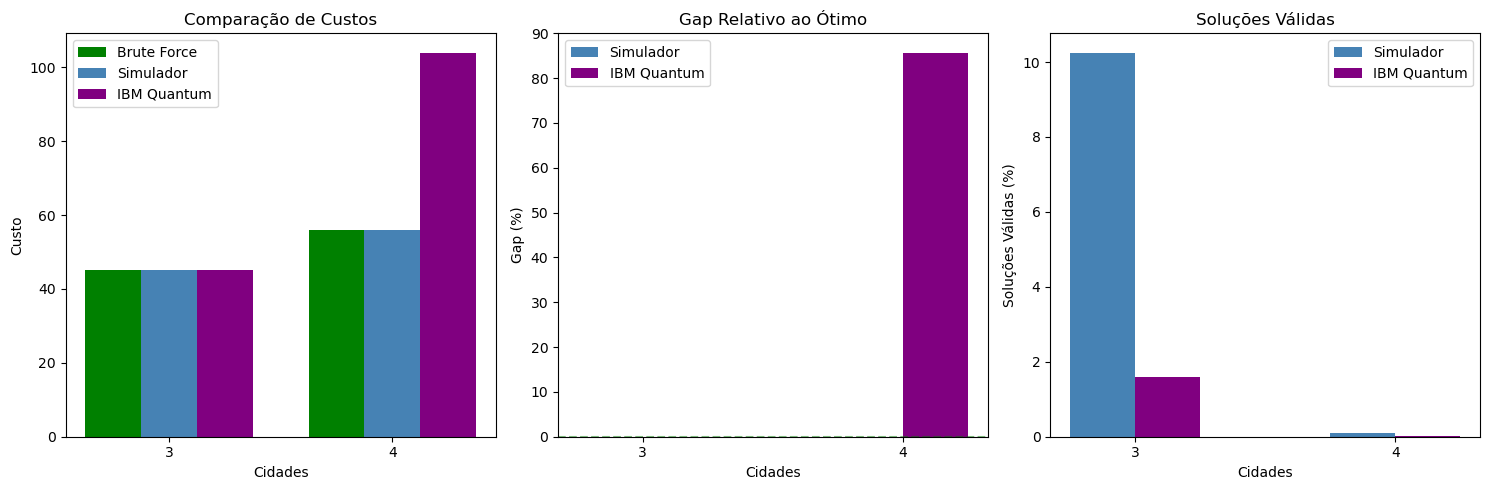

In [31]:
# =============================================================================
# GRÁFICOS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = df_final['Cidades'].values
width = 0.25

# Custos
ax1 = axes[0]
custos_sim = [c if c != 'N/A' else 0 for c in df_final['Custo Simulador']]
custos_ibm = [c if c != 'N/A' else 0 for c in df_final['Custo IBM']]
ax1.bar(x - width, df_final['Custo Ótimo'], width, label='Brute Force', color='green')
ax1.bar(x, custos_sim, width, label='Simulador', color='steelblue')
ax1.bar(x + width, custos_ibm, width, label='IBM Quantum', color='purple')
ax1.set_xlabel('Cidades')
ax1.set_ylabel('Custo')
ax1.set_title('Comparação de Custos')
ax1.legend()
ax1.set_xticks(x)

# Gap
ax2 = axes[1]
gaps_sim = [g if g != 'N/A' else 100 for g in df_final['Gap Sim (%)']]
gaps_ibm = [g if g != 'N/A' else 100 for g in df_final['Gap IBM (%)']]
ax2.bar(x - width/2, gaps_sim, width, label='Simulador', color='steelblue')
ax2.bar(x + width/2, gaps_ibm, width, label='IBM Quantum', color='purple')
ax2.set_xlabel('Cidades')
ax2.set_ylabel('Gap (%)')
ax2.set_title('Gap Relativo ao Ótimo')
ax2.legend()
ax2.set_xticks(x)
ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)

# Válidas
ax3 = axes[2]
ax3.bar(x - width/2, df_final['Válidas Sim (%)'], width, label='Simulador', color='steelblue')
ax3.bar(x + width/2, df_final['Válidas IBM (%)'], width, label='IBM Quantum', color='purple')
ax3.set_xlabel('Cidades')
ax3.set_ylabel('Soluções Válidas (%)')
ax3.set_title('Soluções Válidas')
ax3.legend()
ax3.set_xticks(x)

plt.tight_layout()
plt.savefig('resultados_ibm_quantum.png', dpi=150)
plt.show()

In [32]:
# =============================================================================
# ANÁLISE FINAL
# =============================================================================

print("\n" + "=" * 70)
print("📈 ANÁLISE: SIMULADOR vs IBM QUANTUM")
print("=" * 70)

print("\n🔹 SIMULADOR (sem ruído):")
print(f"   • Média soluções válidas: {df_final['Válidas Sim (%)'].mean():.2f}%")

print(f"\n🔹 IBM QUANTUM ({df_final['Backend'].iloc[0]}):")
print(f"   • Média soluções válidas: {df_final['Válidas IBM (%)'].mean():.2f}%")

print("\n🔹 IMPACTO DO RUÍDO:")
diff = df_final['Válidas Sim (%)'].mean() - df_final['Válidas IBM (%)'].mean()
print(f"   • Redução em soluções válidas: {diff:.2f}%")

print("\n🔹 CONCLUSÕES:")
print("   • Hardware real tem mais ruído que simulador")
print("   • Técnicas de mitigação de erros podem melhorar")
print("   • QAOA funciona, mas com degradação")


📈 ANÁLISE: SIMULADOR vs IBM QUANTUM

🔹 SIMULADOR (sem ruído):
   • Média soluções válidas: 5.18%

🔹 IBM QUANTUM (ibm_fez):
   • Média soluções válidas: 0.81%

🔹 IMPACTO DO RUÍDO:
   • Redução em soluções válidas: 4.37%

🔹 CONCLUSÕES:
   • Hardware real tem mais ruído que simulador
   • Técnicas de mitigação de erros podem melhorar
   • QAOA funciona, mas com degradação


In [ ]:
# Exportar
df_final.to_csv('resultados_tsp_ibm_quantum.csv', index=False)
print("\n📁 Resultados salvos em 'resultados_tsp_ibm_quantum.csv'")